In [1]:
import numpy as np
from math import comb
import tqdm
from helpers import projection_simplex_sort
import copy
import matplotlib.pyplot as plt
import itertools as it
import os
import statistics
import seaborn as sns; sns.set()
import itertools


ModuleNotFoundError: No module named 'helpers'

In [10]:
class TeamGame:
	#inputs: num players, max facilities per player, list of linear multiplier on utility for num of players
	def __init__(self, n):
		self.n = n # num of players
		self.epsilon = 1/(10*n)
		self.actions = [ np.random.choice(2, 1)[0] for i in range(n)]
		self.num_actions = 2
		self.all_states = [0, 1]
		self.S = len(self.all_states) # num_states


	def get_counts(self, actions):
		return np.sum(actions)

	def get_public_rewards(self, actions, state):
		density = self.get_counts(actions)
		if density < self.n / 2:
			return 0, 0
		else:
			return 1, r(state)

def r(s):
    return s
        

def xi(i, s, a, n, epsilon):
	"""
	Free feel to modify this part
    """
	xi = (s ==a) * ((n+1 -i)/n)  * 5 - a * ((i+1)/n)
	return xi * epsilon

def get_reward(game, actions, state):
	agents_rewards = game.n * [0]

	density, public_reward = game.get_public_rewards(actions, state)
	if density == 0:
		return agents_rewards
	
	for i in range(game.n):
		agents_rewards[i] = public_reward + xi(i, state, actions[i], game.n, game.epsilon)
	return agents_rewards




In [11]:
"""
High to High: density >= n/4
        Low:  density < n/4

Low to High: density >= n/2
       Low:  dentiy < n/2
"""
def sample_next_state(game, state, actions):
    """deterministic transition"""
    density = game.get_counts(actions)
    

    if state == 0 and density >= game.n/2 or state == 1 and density >= game.n/4:
        return 1
    return 0

In [12]:

def pick_action(prob_dist):
    # np.random.choice(range(len(prob_dist)), 1, p = prob_dist)[0]
    acts = [i for i in range(len(prob_dist))]
    action = np.random.choice(acts, 1, p = prob_dist)
    return action[0]


def value_function(game, policy, gamma, T, samples):
    """
    O(num_samples * S * T) 
    get value function by generating trajectories and calculating the rewards
    Vi(s) = sum_{t<T} gamma^t r(t)
    """
    S= game.S
    N = game.n
    
    selected_profiles = {}
    value_fun = {(s,i): 0 for s in range(S) for i in range(N)}
    for k in range(samples):
        for state in range(S):
            curr_state = state
            for t in range(T):
                actions = [pick_action(policy[curr_state, i]) for i in range(N)]  # N: num of players
                q = tuple(actions+[curr_state])
                # setdefault(key, value): if key exists in dic, return its original value in dic. Else, add this new key and value into dic 
                rewards = selected_profiles.setdefault(q, get_reward(game, actions, state))                  
                for i in range(N):
                    value_fun[state,i] += (gamma**t)*rewards[i]
                curr_state = sample_next_state(game, curr_state, actions)
    value_fun.update((x,v/samples) for (x,v) in value_fun.items())
    return value_fun

def Q_function(game, agent, state, action, policy, gamma, value_fun, samples):
    """
    Q = r(s, ai) + gamma * V(s)
    """
    selected_profiles = {}
    N = game.n

    tot_reward = 0
    for i in range(samples):
        actions = [pick_action(policy[state, i]) for i in range(N)]
        actions[agent] = action
        q = tuple(actions+[state])
        rewards = selected_profiles.setdefault(q, get_reward(game, actions, state))
        tot_reward += rewards[agent] + gamma*value_fun[sample_next_state(game, state, actions), agent]
    return (tot_reward / samples)

In [13]:
def policy_accuracy(policy_pi, policy_star, N, S):
    total_dif = N * [0]
    for agent in range(N):
        for state in range(S):
            total_dif[agent] += np.sum(np.abs((policy_pi[state, agent] - policy_star[state, agent])))
	  # total_dif[agent] += np.sqrt(np.sum((policy_pi[state, agent] - policy_star[state, agent])**2))
    return np.sum(total_dif) / N

def policy_gradient(game, max_iters, gamma, eta, T, samples, kappa, M, S, N):

    policy = {(s,i): [1/M]*M for s in range(S) for i in range(N)}
    policy_hist = [copy.deepcopy(policy)]

    for t in tqdm.tqdm(range(max_iters)):
        eta_ = 0.99**t * eta
        b_dist = M * [1]
            
        grads = np.zeros((N, S, M))
        value_fun = value_function(game, policy, gamma, T, samples)
	
        for agent in range(N):
            for st in range(S):
                for act in range(M):
                    grads[agent, st, act] = b_dist[st] * Q_function(game, agent, st, act, policy, gamma, value_fun, samples)

        for agent in range(N):
            for st in range(S):
                policy[st, agent] = projection_simplex_sort(np.add(policy[st, agent], eta_ * grads[agent,st]), z=1)
        policy_hist.append(copy.deepcopy(policy))

        if policy_accuracy(policy_hist[t], policy_hist[t-1],  N, S) < 10e-16:
            return policy_hist

    return policy_hist

 48%|███████████████████▋                     | 192/400 [00:42<00:46,  4.50it/s]


 96%|███████████████████████████████████████▌ | 386/400 [01:25<00:03,  4.56it/s]


 44%|██████████████████▏                      | 178/400 [00:39<00:48,  4.58it/s]


 93%|██████████████████████████████████████▏  | 372/400 [01:21<00:06,  4.48it/s]


100%|█████████████████████████████████████████████| 2/2 [02:56<00:00, 88.38s/it]


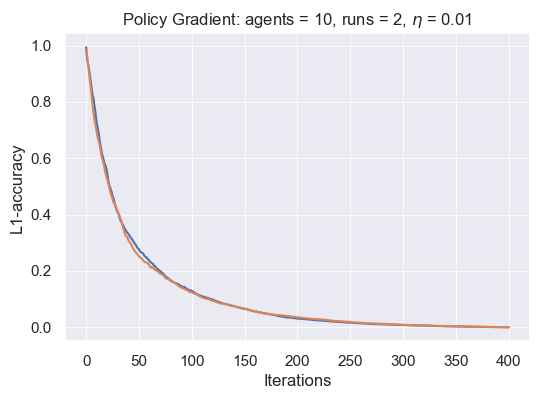

/Users/chinmaymaheshwari/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


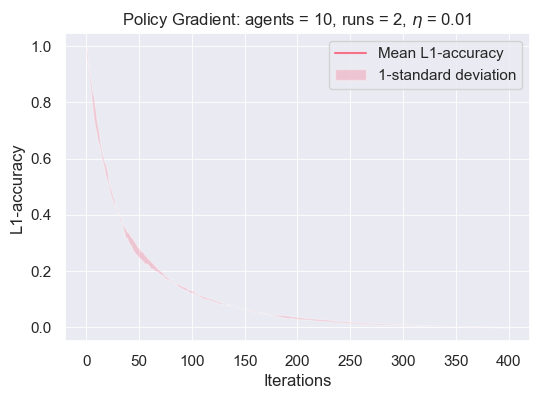

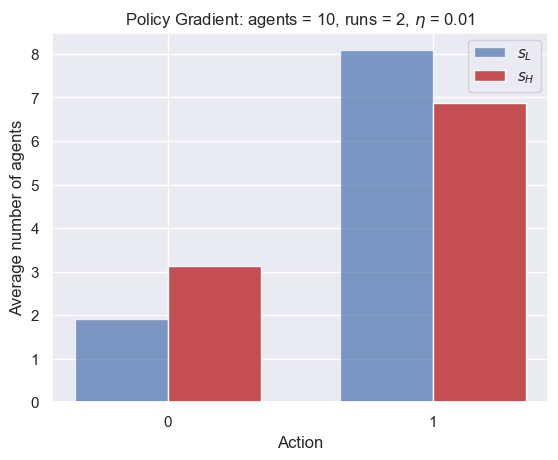

(<Figure size 600x400 with 1 Axes>,
 <Figure size 600x400 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

In [14]:
def get_accuracies(policy_hist,  N, S):
    fin = policy_hist[-1]
    accuracies = []
    for i in range(len(policy_hist)):
        this_acc = policy_accuracy(policy_hist[i], fin,  N, S)
        accuracies.append(this_acc)
    return accuracies



def full_experiment(game, runs,iters,eta,T,samples, kappa):
    S, N, all_states, M = game.S, game.n, game.all_states, game.num_actions
    path = "team_model_results/kappa_"+str(kappa) + "/"
    if not os.path.exists(path):
        os.makedirs(path)
    densities = np.zeros((S,M))

    raw_accuracies = []
    for k in tqdm.tqdm(range(runs)):
        policy_hist = policy_gradient(game, iters,0.99,eta,T,samples, kappa, M, S, N)
        raw_accuracies.append(get_accuracies(policy_hist, N, S))

        converged_policy = policy_hist[-1]
        for i in range(N):
            for s in range(S):
                st = all_states[s]
                densities[s] += converged_policy[st,i]

    densities = densities / runs


    # Plot Figure 1: trajectories of L1 accuracy
    plot_accuracies = np.array(list(itertools.zip_longest(*raw_accuracies, fillvalue=np.nan))).T
    clrs = sns.color_palette("husl", 3)
    piters = list(range(plot_accuracies.shape[1]))

    fig2 = plt.figure(figsize=(6,4))
    for i in range(len(plot_accuracies)):
        plt.plot(piters, plot_accuracies[i])
    plt.grid(linewidth=0.6)
    plt.gca().set(xlabel='Iterations',ylabel='L1-accuracy', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N, runs,eta))
    plt.show()
    fig2.savefig(path + 'individual_runs_n{}.png'.format(N),bbox_inches='tight')

    plot_accuracies = np.nan_to_num(plot_accuracies)
    pmean = list(map(statistics.mean, zip(*plot_accuracies)))
    pstdv = list(map(statistics.stdev, zip(*plot_accuracies)))
    
    fig1 = plt.figure(figsize=(6,4))
    ax = sns.lineplot( pmean, color = clrs[0],label= 'Mean L1-accuracy')
    ax.fill_between(piters, np.subtract(pmean,pstdv), np.add(pmean,pstdv), alpha=0.3, facecolor=clrs[0],label="1-standard deviation")
    ax.legend()
    plt.grid(linewidth=0.6)
    plt.gca().set(xlabel='Iterations',ylabel='L1-accuracy', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N, runs,eta))
    plt.show()
    fig1.savefig('network_state/kappa_'+str(kappa)+'/avg_runs_n{}.png'.format(N),bbox_inches='tight')
    
    fig3, ax = plt.subplots()
    index = np.arange(M)
    bar_width = 0.35
    opacity = 1
    rects1 = plt.bar(index, densities[0], bar_width, alpha= .7 * opacity, color='b', label=r'$s_L$')

    rects2 = plt.bar(index + bar_width, densities[1], bar_width, alpha= opacity, color='r', label=r'$s_H$')

    plt.gca().set(xlabel='Action',ylabel='Average number of agents', title='Policy Gradient: agents = {}, runs = {}, $\eta$ = {}'.format(N,runs,eta))
    plt.xticks(index + bar_width/2, (0, 1) )
    plt.legend()
    fig3.savefig('network_state/kappa_'+str(kappa)+'/facilities_n{}.png'.format(N),bbox_inches='tight')
    plt.show()

    return fig1, fig2, fig3


# kappa is the parameter in logisitic function.
# If you want deterministic transition, set kappa="deterministic"
runs,iters,eta,T,samples, kappa = 2, 400, 0.01, 20,10,"deterministic"
game = TeamGame(10)
full_experiment(game, runs,iters,eta,T,samples, kappa)